In [1]:
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


# Plot avg cloud probability across time
adaptation from: https://github.com/fitoprincipe/ipygee/blob/master/examples/Chart.ipynb

In [27]:
from utils import get_project_data
from datetime import datetime
from ipygee import chart
import pandas as pd
import ee
ee.Initialize(project="ee-walteliot")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np

In [3]:
# Arguments
all_projects = ['346', '342', '9', '341', '354', '415', '418', '416', '426', '429', '439', '560', '472', '521', '498',
           '522', '564', '764', '781', '825', '796', '805', '827', '891', '835', '920', '959', '1023', '998',
           '909', '819', '896', '528', '527', '477', '542', '537', '792', '471', '769', '988']
collection_start_date = datetime.strptime("2017-03-28T00:00:00", "%Y-%m-%dT%H:%M:%S")
projection = ee.Projection("EPSG:4326")
cloud_proba_band = "MSK_CLDPRB"
scale = 100
band_name = f"CLDPRB{scale}"

In [4]:
# Collect project data
gt_dates, bboxes, projects = [], [], []
for project in all_projects:
    _, _, _, gt_date, _, _, bbox = get_project_data(
        project,
        gt_dir="../assets/data/preprocessed",
        gt_data_bands=list(range(1,6)),
        shapefile_paths=['../assets/data/NHM_projectDekning_AOI_edit2015_V2.shp', 
                        '../assets/data/ALS_projects_Dz_all_norway.shp']
    )
    if gt_date >= collection_start_date:
        projects.append(project)
        gt_dates.append(gt_date)
        bboxes.append(bbox)
print(f"Found {len(projects)} projects matching minimum date")

Found 26 projects matching minimum date


In [8]:
# Collect GEE data
start_date = ee.Date(min(gt_dates))
end_date = ee.Date(max(gt_dates)).advance(60, "day")
df = pd.DataFrame()
for i, project, bbox in enumerate(zip(projects, bboxes)):
    print(f"Processing project: {project} ({i+1}/{len(projects)})")
    geometry = ee.Geometry.Rectangle(bbox, proj=projection)
    timeserie = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                    .filterBounds(geometry)
                    .filterDate(start_date, end_date)
                    .select(cloud_proba_band))
    print(f"- Got {timeserie.size().getInfo()} images")
    try:
        data = chart.Image.series(
            imageCollection=timeserie,
            region=geometry,
            scale=scale,
            bands=[cloud_proba_band],
            label_bands=[band_name],
            maxPixels=1000000000
        )
        # make data
        pdf = data.dataframe.reset_index().rename(columns={"index": "date"})
        pdf["project"] = project
        # concat
        df = pd.concat([df, pdf], axis=0)
        print(f"- Overall avg cloud probability: {pdf[band_name].mean()}")
    except Exception as e:
        print(f"Could not aggregate timeserie: {e}")

Processing project: 9
- Got 779 images
- Overall avg cloud probability: 39.18873693496949
Processing project: 415
- Got 498 images
- Overall avg cloud probability: 39.08604218054013
Processing project: 416
- Got 880 images
- Overall avg cloud probability: 36.58477739513421
Processing project: 560
- Got 581 images
- Overall avg cloud probability: 35.923836131229386
Processing project: 564
- Got 1322 images
- Overall avg cloud probability: 33.26567352259312
Processing project: 764
- Got 202 images
- Overall avg cloud probability: 39.90881252298815
Processing project: 781
- Got 203 images
- Overall avg cloud probability: 40.36342508976585
Processing project: 825
- Got 202 images
- Overall avg cloud probability: 40.71115584441485
Processing project: 796
- Got 281 images
- Overall avg cloud probability: 25.79505838193012
Processing project: 805
- Got 192 images
- Overall avg cloud probability: 37.836316356179665
Processing project: 827
- Got 397 images
- Overall avg cloud probability: 40.80

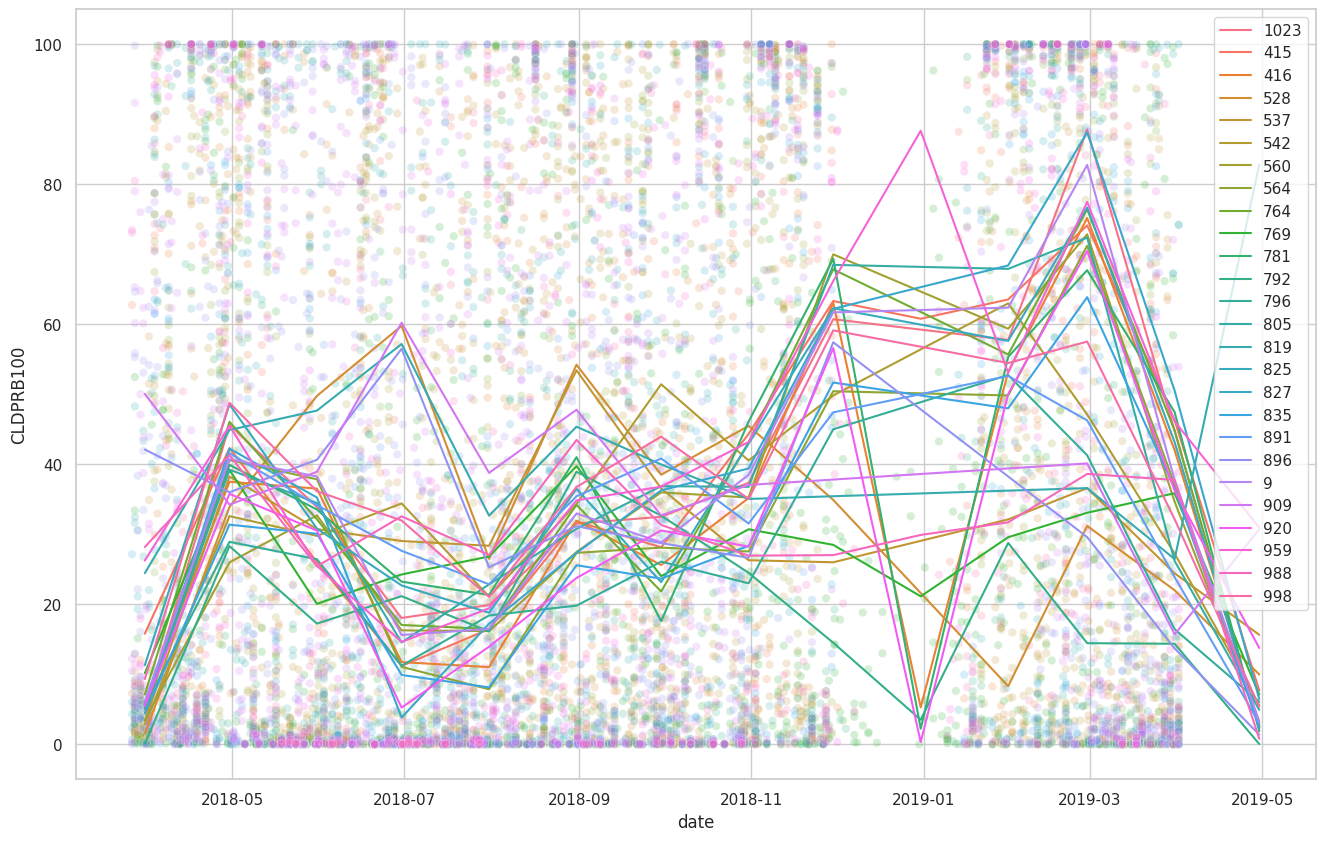

In [71]:
# plot
dfm = df.groupby("project").resample("M", on="date").mean().reset_index()
df = df.sort_values(by=["project", "date"])
dfm = dfm.sort_values(by=["project", "date"])
fig = plt.figure(figsize=(16,10))
sns.scatterplot(data=df, x="date", y=band_name, hue="project", alpha=.2)
sns.lineplot(data=dfm, x="date", y=band_name, hue="project")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig("avg_cloud_probability.png")
plt.show()